# Speech Inpainting






## Introduction

Clicks can be considered as transient high-amplitude noise corrupting portions of the signal such that the information is completely lost. These corrupted portions are called *gaps*. The problem of restoring the lost information is known in litterature as *audio inpainting*, *audio interpolation*, or *waveform substitution*. And the approaches vary according to the audio type (music, speech, etc.), the gaps lengths (few milliseconds, hundreds of milliseconds, and more) and whether to work in the temporal or spectral domain. The majority of previous work focus on gaps ranging from few milliseconds to hundred milliseconds. Recently, increase in performance was achieved by leveraging meta data such as video [[Morrone et al.]](https://https://arxiv.org/abs/2010.04556) or text [[Borsos et al.]](https://https://arxiv.org/abs/2202.07273).

Our problem concerns mainly identical clicks forming gaps of $100$ ms. The gaps can collide and form longer ones up to $600$ ms, or come at the end or beginning of the audio and thus have smaller durations. Moreover, our audio consist of a speech from a single person. The closest work to ours are [[Kegler et al.]](https://arxiv.org/abs/1910.09058) and  [[Marafioti et al.]](https://ieeexplore.ieee.org/document/8867915). [[Kegler et al.]](https://arxiv.org/abs/1910.09058) tackle speech gaps up to $400$ ms, as well as frequency and time-frequency gaps. Their approach is inspired by Image Inpainting, particularly [[Liu et al.]](https://arxiv.org/abs/1804.07723). An audio is represented by its spectrogram, which is similar to an image, and it is fed to a UNET with Partial Convolutions. We mainly based our model or their architecture. However, to simulate the gaps, they take a clean dataset, compute the spectrogram of each speech and then randomly mask windows in the time-frequency representation. This is different from our case and not realistic, as the temporal distortion usually occur in the wave signal, before dividing it into overlapping windows. Moreover, they optimize a Deep Feature loss using a VGG, which we don't do.

### Imports: Scripts and data

In [ ]:
# Download the data
!gdown "https://drive.google.com/uc?id=1Po0KozQGF_t6ym-RNap9MRWXZcsbSBTY&confirm=t"
# Download the scripts
!gdown "https://drive.google.com/uc?id=1U_4O7E_9JTeh6fgj3geyNmlftLP_LLd6&confirm=t"
!gdown "https://drive.google.com/uc?id=10I6Z_t_MIbf6o3_7jS_eZaXexC5b0uSp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1Po0KozQGF_t6ym-RNap9MRWXZcsbSBTY&confirm=t
To: /content/Données suppression de clicks-20221214.zip
100% 838M/838M [00:18<00:00, 46.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1U_4O7E_9JTeh6fgj3geyNmlftLP_LLd6&confirm=t
To: /content/speech_inpainting_models.py
100% 15.1k/15.1k [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=10I6Z_t_MIbf6o3_7jS_eZaXexC5b0uSp&confirm=t
To: /content/speech_inpainting_dataset.py
100% 7.06k/7.06k [00:00<00:00, 13.6MB/s]


In [ ]:
!pip install pystoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7792 sha256=1a860362b2053453f51a8be612478a0f26deb1ce204d8574297c980ad57d0640
  Stored in directory: /root/.cache/pip/wheels/62/35/75/c07f0861a60fb8aacf44fdd5c8c214a224a6c9edb4a4e1402f
Successfully built pystoi


In [ ]:
import os
import shutil
import zipfile 
from tqdm import tqdm

import copy
import numpy as np
from scipy.signal import correlate, stft, windows, medfilt

from matplotlib import pyplot as plt

import librosa 
import librosa.display
import IPython.display as ipd
from IPython.display import Audio
from librosa import griffinlim

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import interpolate

from pystoi import stoi

In [ ]:
from speech_inpainting_dataset import (get_clicks_positions, get_clicks_windows, 
                                       Dataset, Audio_from_STFT, display_example)
from speech_inpainting_models import (UNET, UNET_PartialConv, Loss_Partial, NMSE)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Fix seeds
torch.manual_seed(0)
np.random.seed(0)

cuda:0


In [ ]:
# Extract folder
with zipfile.ZipFile("/content/Données suppression de clicks-20221214.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
# Extract files
for f in ["clicks", "ref"]:
  for s in ["test","train"]:
      if os.path.exists(f"/content/{f}_{s}"):
        continue
      with zipfile.ZipFile(f"/content/voix{f}_{s}.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/")
        os.rename(f"/content/{s}", f"/content/{f}_{s}")

## Data Exploration and Analysis

We begin with displaying and listening to some corrupted audio.

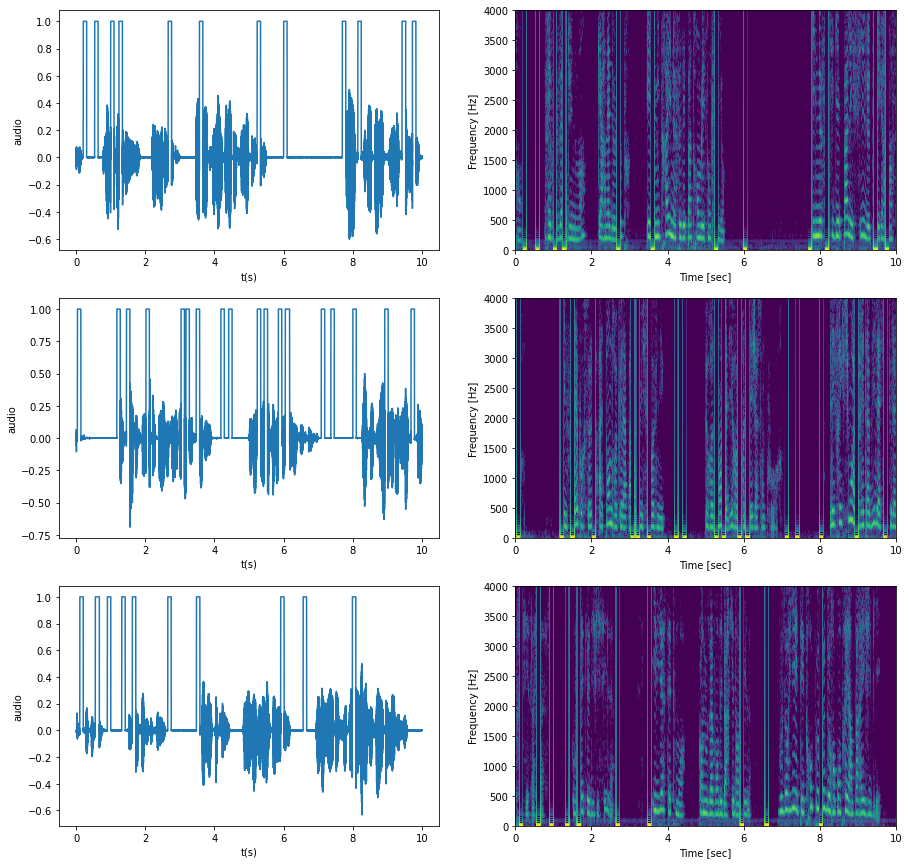

In [ ]:
n_samples = 3
dir = "/content/clicks_train/"
random_audio = np.random.choice(os.listdir(dir), 
                                size = n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize = (15,5 * n_samples))

for i, file_audio in enumerate(random_audio):

  data, rate = librosa.load(dir + file_audio, sr = None)
  time = np.arange(len(data))/rate
  # Plot temporal wave
  axes[i,0].plot(time, data)
  axes[i,0].set_xlabel("t(s)")
  axes[i,0].set_ylabel("audio")
  # Plot Spectrogram (Default: Hann window)
  f, t, sp = stft(data, rate, nperseg = 256, nfft = 1024, noverlap = 128)
  sp = librosa.amplitude_to_db(np.abs(sp), ref=np.max)
  axes[i,1].pcolormesh(t,f,  sp)
  axes[i,1].set_ylabel('Frequency [Hz]')
  axes[i,1].set_xlabel('Time [sec]')
  # Audio
  ipd.display(Audio(data = data, rate = rate))




>From the plot we notice that the clicks have the highest intensity (=1) in all audio. Therefore, we can easily detect them and perform some statistics to analyse the data.

In [ ]:
# Detecting clicks in audio
duration_audio = []
n_clicks = []
duration_clicks = []
dir = "/content/clicks_train/"
for file_audio in tqdm(os.listdir(dir)):
  # Read audio
  data, rate = librosa.load(dir + file_audio, sr = None)
  # Detect clicks
  starts, ends = get_clicks_positions(data)
  # Save number and duration
  n_clicks.append(len(starts))
  duration_clicks.append(ends - starts)
  duration_audio.append(len(data))


100%|██████████| 2118/2118 [00:02<00:00, 1042.47it/s]


Text(0.5, 0, 'Percentage')

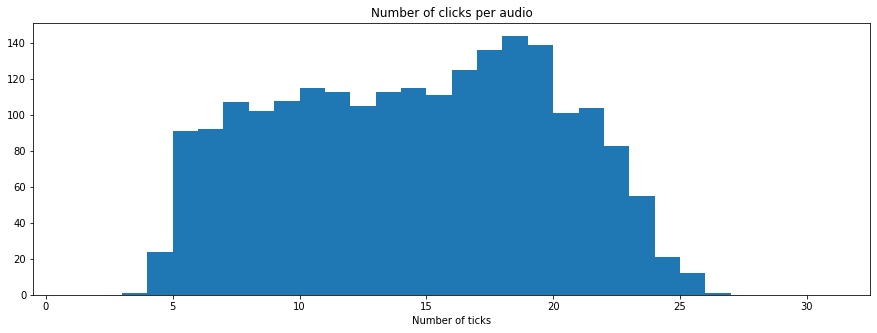

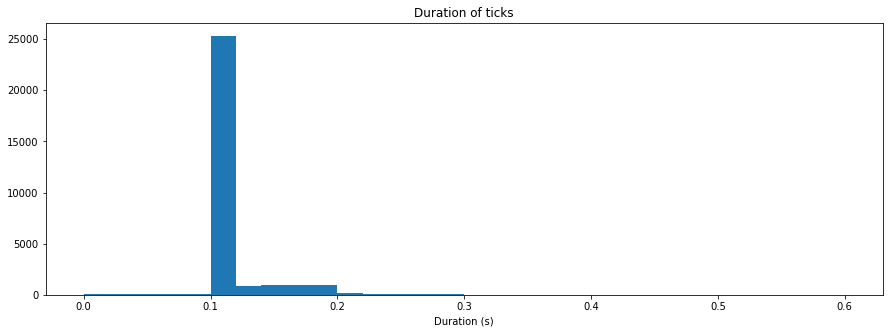

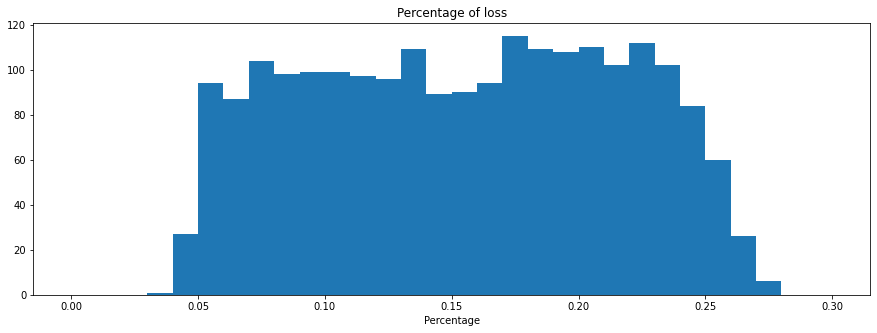

In [ ]:
duration_audio = np.unique(duration_audio)[0]
gaps_size = [np.sum(d)/duration_audio for d in duration_clicks]
# Number of clicks
plt.figure(figsize=(15,5))
plt.hist(n_clicks, bins = 30, range =(1,31));
plt.title("Number of clicks per audio")
plt.xlabel("Number of ticks")
# Duration of clicks
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(duration_clicks)/rate, bins = 30, range=(0,0.6));
plt.title("Duration of ticks")
plt.xlabel("Duration (s)")
# Percentage of loss
plt.figure(figsize=(15,5))
plt.hist(gaps_size, bins = 30, range = (0,0.3))
plt.title("Percentage of loss")
plt.xlabel("Percentage")

>The duration of the clicks is mostly 100 ms and can extend to 600 ms. 

## Baselines

In [ ]:
# Check dataset
train_dir = "/content/clicks_train/"
test_dir = "/content/clicks_test/"

print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))

# Split train set
len_full = len(os.listdir(train_dir))
val_ratio = 0.15

i_val = np.random.choice(np.arange(len_full), 
                             size = int(len_full*val_ratio),
                             replace = False)

names_val = np.array(os.listdir(train_dir))[i_val]
names_train = np.array(os.listdir(train_dir))[
    ~np.isin(np.arange(len_full), i_val)]

print(len(names_val))
print(len(names_train))

2118
782
317
1801


### Audio processing

>In this section we are going to use audio processing methods in order to remove the clicks.

Windowed interpolation is a technique used to interpolate a signal by multiplying it with a window function before and after interpolation. The goal of windowing is to reduce the spectral leakage caused by interpolating a signal with a rectangular window. Spectral leakage is a phenomenon that occurs when a signal is interpolated using a rectangular window, which can cause the frequency components of the signal to spread out into adjacent frequency bins, resulting in a distorted signal.

In windowed interpolation, a window function, such as the Hann window, Hamming window, Blackman window, Bartlett window, or Parzen window is multiplied with the signal before interpolation and after interpolation. The window function helps to smooth the transition between the originalsignal and the interpolated signal, reducing the amount of spectral leakage.

The window size can be adjusted to control the trade-off between interpolation accuracy and spectral leakage. A larger window size will result in less spectral leakage but less accurate interpolation, while a smaller window size will result in more accurate interpolation but more spectral leakage.
It's worth noting that windowed interpolation is not a complete solution to spectral leakage, but it's a common technique used to reduce the impact of spectral leakage on the interpolated signal.


In [ ]:
def remove_clicks(audio, sample_rate, threshold, window='hamming', window_size=15):
    """Remove clicks from audio signals using a simple thresholding algorithm
    
    Parameters:
    audio (ndarray): The audio signal as a 1-D numpy array
    sample_rate (int): The sample rate of the audio signal (in Hz)
    threshold (float): The threshold level for detecting clicks (in dB)
    window (str): The window to use for windowed interpolation. 
        Options: 'hann', 'hamming', 'blackman', 'bartlett', 'parzen'
    window_size (int): The size of the median filter window.
    Returns:
    ndarray: The audio signal with clicks removed
    """
  
    # Find samples with amplitude above threshold
    click_samples = np.where(np.abs(audio) > threshold)[0]
    
    # Interpolate over click samples
    if click_samples[0] == 0:
        click_samples[0] = 1
    start = max(0, click_samples[0]-1)
    end = min(audio.shape[0]-1, click_samples[-1]+1)
    audio[click_samples] = np.interp(click_samples, (start, end), (audio[start], audio[end]))
    
    # Apply windowed interpolation
    window = windows.get_window(window, click_samples.size)
    audio[click_samples] *= window
    
    # Apply median filter
    audio[click_samples] = medfilt(audio[click_samples], kernel_size=window_size)
    
    
    return audio

In [ ]:
#test on random audio file
dir = "/content/clicks_train/"
random_audio = np.random.choice(os.listdir(dir), size = 1)

data, rate = librosa.load(dir + random_audio[0], sr = None)
data_copy=data.copy()
no_clicks_w=remove_clicks(data,rate, 0.7,window_size=13)

#listen to the audios random_audio and no_clicks
print('original audio file')
ipd.display(Audio(data = data_copy, rate = rate))


print('processed audio file')
ipd.display(Audio(data = no_clicks_w, rate = rate))

original audio file


processed audio file


In [ ]:
# Compute metrics
dir_test = "/content/clicks_test/"
p = 0
for file_name in tqdm(os.listdir(dir_test)):
  data, rate = librosa.load(dir_test + file_name, sr = None)
  data_copy=data.copy()
  no_clicks_w=remove_clicks(data,rate, 0.7,window_size=13)
  
  p += stoi(data_copy, no_clicks_w, rate, extended=False)

100%|██████████| 782/782 [02:03<00:00,  6.32it/s]


In [ ]:
print(f"STOI: {p/len(os.listdir(dir_test)):.3f}")

STOI: 0.768




## Loss functions
#### Normalized MSE
Following the work done in [[Marafioti et. al]](https://ieeexplore.ieee.org/document/8867915), the reconstruction loss is computed by comparing the original gap STFT with the reconstructed gap TF. They optimize a normalized MSE. A normal MSE would give more weight to the signals with more energy (more clicks).

The loss has the following formula,

\begin{equation}
  l(S_{rec}, S_{ref}) = \frac{\|(S_{rec} - S_{ref})*(1-m)\|}{c^{-1} + \|S_{ref} * (1-m)\|}
\end{equation}


Where $S_{rec}$ and $S_{ref}$ are the reconstructed and the reference spectrogram respectively, $m$ is the binary mask having $0$ on gap pixels and $c$ is added to compensate small amplitudes. In [[Marafioti et. al]](https://ieeexplore.ieee.org/document/8867915), $c=5$.

#### Partial Loss
In  [[Liu et al.]](https://arxiv.org/abs/1804.07723), they use a combination of losses from which we selected the following.

\begin{align}
 l(S_{rec}, S_{ref}) &=  \alpha * l_{hole}(S_{rec}, S_{ref}) + l_{valid}(S_{rec}, S_{ref})\\
                    &= \alpha * \|(S_{rec} - S_{ref})*(1-m)\| + \|(S_{rec} - S_{ref})*m\|
\end{align}

### Metrics
As for metrics, we chose the Short-Time Objective Intelligibility (STOI). Which is based on a correlation coefficient between the temporal envolops of the time-aligned reference and the reconstructed speech signal in short-time overlapped segments.

## Model

Our model consists of a UNET inspired by [[Kegler et al.]](https://arxiv.org/abs/1910.09058) which we train from scratch. It is composed of a 6 layers encoder and a symmetrical decoder. We start our experiments differently from [[Kegler et al.]](https://arxiv.org/abs/1910.09058) using normal convolutional layers. After training for $15$ epochs with a learning rate equal to $1$ and the Partial Loss, the gaps of the obtained reconstructed Spectrogram were very blurry with respect to the ground truth. We test with both losses and observe very similar results. The corresponding STOI is $0.796$ which is an increase of $0.03$ from the baseline, but lower than $0.811$ obtained for temporal intrusions of $30\%$  in [[Kegler et al.]](https://arxiv.org/abs/1910.09058). 

We argue that the blurry reconstruction is caused by the last decoder layer, where the final feature map and the masked input Spectrogram are concatenated and fed to a 2D Convolution Layer. The model will tend to give high weights to the masked input i.e. to the second channel, so it predicts a large number of the pixels correctly. Since, the same and only filter will be used to fill the gap, where the second channel is null, the corresponding output will necessarily have a low intensity. This effect will also be present in Partial Convolutions. In order to tackle this problem, we conducted two further experiments. 

##### **Exp 2: Interpolation**
First, we considered filling the gap of the input Spectrogram with an initial estimtation. We needed the estimation to be fast, therefore we used Numpy's linear interpolation per frequency line. And we expected the final feature to be a correction with low intenisty of this initial estimation. However, after testing it, we conclude that the model didn't alter as much the estimations in the gap. 

##### **Exp 3: Sum**
For, the second experiment, we decided to ommit the concatenation and replace it with a sum of the masked input and the last feature map. Even with this change, we didn't observe a big improvement of the performance.

## Data augmentation
The dataset has an option to return augmented data. The augmented data is computed by randomly corrupting $0.1$ seconds gaps of the waveform to result in a total disortion ranging between $10\%$ to $25\%$.

## Training 

In [ ]:
# ===== Trainer =====
class Trainer:
  def __init__(self, model, criterion, optimizer, device):
    self.device = device

    # set model
    self.model = model.to(self.device)
    # set optim
    self.criterion = criterion
    self.optimizer = optimizer

    # init curves
    self.losses_train = []
    self.losses_val = []


  def train(self, dataset_train, dataset_val = None, n_epochs = 5, 
            batch_size = 32, enable_autocast = False, enable_GradScaler = False):

    c = 5

    # prep dataloader
    dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size = batch_size,
                                               shuffle = True)

    # Gradient scaler
    scaler = torch.cuda.amp.GradScaler(enabled= enable_GradScaler)
    
    min_loss = np.inf

    # Start training
    for i_epoch in range(n_epochs):

      running_loss = 0
      for i_batch, batch_data in enumerate(tqdm(dataloader_train)):
        
        self.model.train()

        with torch.autocast(device_type="cuda", dtype = torch.float16, 
                            enabled = enable_autocast):
          
          # Data to GPU
          S_clicks = batch_data["S_clicks"].unsqueeze(1).to(self.device)
          mask_clicks = batch_data["mask_clicks"].unsqueeze(1).to(self.device)
          S_ref = batch_data["S_ref"].to(self.device)
          
          # forward 
          S_rec = self.model(S_clicks, mask_clicks).squeeze()
    
          loss = self.criterion(S_rec, S_ref, mask_clicks)

        # Compute gradients
        scaler.scale(loss).backward()
        # Grad step
        scaler.step(self.optimizer)
        scaler.update()
        # Zero grads
        self.optimizer.zero_grad()

        running_loss += loss.item()

      torch.cuda.empty_cache()

      running_loss /= len(dataloader_train)
      self.losses_train.append(running_loss)

      # Evaluate on validation set
      loss_val = self.predict(dataset_val, batch_size)["loss"]
      self.losses_val.append(loss_val)
      # Log metrics
      print(f"\nEpoch {i_epoch} | "
            f"loss_train: {running_loss:<8.3f} | "
            f"loss_val: {loss_val:<8.3f}\n")
      
      if loss_val < min_loss:
        min_loss = loss_val
        print("Best model saved.\n")
        self.best_model = copy.deepcopy(self.model)

  def predict(self, dataset, batch_size = 64, enable_auatocast = False, 
              return_metrics = False):
    """
    Evaluates the model i.e. returns scores and loss for the given dataset
    """
    # prep dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                             shuffle = False)
    
    # init curves
    scores = []
    labels = []
    loss = 0
    p = 0
    # evaluate
    for batch_data in tqdm(dataloader):
      self.model.eval()
      
      # data to gpu
      
      # Mask clicks
      S_clicks = batch_data["S_clicks"].unsqueeze(1).to(self.device)
      mask_clicks = batch_data["mask_clicks"].unsqueeze(1).to(self.device)

      # forward 
      with torch.no_grad(), torch.autocast(device_type="cuda", 
                        dtype = torch.float16, enabled = enable_auatocast):
        S_rec = self.model(S_clicks, mask_clicks).squeeze()
        
        # loss
        S_ref = batch_data["S_ref"]
        loss += self.criterion((S_rec).cpu(), S_ref, mask_clicks.cpu())

        if return_metrics:
          p += compute_metrics(S_rec.cpu(), batch_data["waveform_ref"])["stoi"]

    dict_metrics = {"loss": loss/len(dataloader)}
    
    if return_metrics:
      dict_metrics["stoi"] = p/len(dataloader)
    
    return dict_metrics

# ===== Metrics =====

def compute_metrics(S_rec, audio_ref):

  d = 0
  p = 0
  rate = 8000
  for i in range(len(audio_ref)):
    audio_rec = Audio_from_STFT(S_rec[i].numpy(), dataset_train.stft_config)
    d += stoi(audio_ref[i].numpy(), audio_rec, rate, extended=False)

  return {"stoi": d/len(audio_ref)}

In [ ]:
# Check dataset
train_dir = "/content/clicks_train/"
test_dir = "/content/clicks_test/"

print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))

# Split train set
len_full = len(os.listdir(train_dir))
val_ratio = 0.15

i_val = np.random.choice(np.arange(len_full), 
                             size = int(len_full*val_ratio),
                             replace = False)

names_val = np.array(os.listdir(train_dir))[i_val]
names_train = np.array(os.listdir(train_dir))[
    ~np.isin(np.arange(len_full), i_val)]

print(len(names_val))
print(len(names_train))

2118
782
317
1801


In [ ]:
dataset_train = Dataset(dir_ref = "/content/ref_train/",
                        dir_clicks = "/content/clicks_train/",
                        names_subset = names_train)

dataset_val = Dataset(dir_ref = "/content/ref_train/",
                        dir_clicks = "/content/clicks_train/",
                        names_subset = names_val)

dataset_test = Dataset(dir_ref = "/content/ref_test/",
                        dir_clicks = "/content/clicks_test/",
                        names_subset = os.listdir("/content/ref_test/"))

stft_config = {"nperseg": 256,  "nfft": 256, "noverlap": 256 - 64 }
dataset_train.stft_config = stft_config
dataset_train.augment = False
dataset_val.stft_config = stft_config
dataset_test.stft_config = stft_config

### Experiment 1 

Model based on [[Kegler et al.]](https://arxiv.org/abs/1910.09058), but with basic convolutions.

In [ ]:
model = UNET(final_sum = False)

# Optimizer
lr = 1
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

trainer = Trainer(model, Loss_Partial, optimizer, device)

Creating model with a basic decoder for the last layer.


In [ ]:
trainer.train(dataset_train, dataset_val, n_epochs = 15, batch_size = 32, 
              enable_autocast = False, enable_GradScaler= False)

Creating model with a basic decoder for the last layer.


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]



Epoch 0 | loss_train: 806.316  | loss_val: 699.776 

Best model saved.



100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Epoch 1 | loss_train: 693.206  | loss_val: 522.258 

Best model saved.



100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Epoch 2 | loss_train: 572.444  | loss_val: 285.025 

Best model saved.



100%|██████████| 10/10 [00:11<00:00,  1.11s/it]



Epoch 3 | loss_train: 451.180  | loss_val: 157.385 

Best model saved.



100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Epoch 4 | loss_train: 331.133  | loss_val: 1055.387



100%|██████████| 10/10 [00:11<00:00,  1.11s/it]



Epoch 5 | loss_train: 217.166  | loss_val: 162.945 



100%|██████████| 10/10 [00:10<00:00,  1.10s/it]



Epoch 6 | loss_train: 129.006  | loss_val: 114.306 

Best model saved.



100%|██████████| 10/10 [00:11<00:00,  1.12s/it]



Epoch 7 | loss_train: 87.271   | loss_val: 290.800 



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]



Epoch 8 | loss_train: 65.759   | loss_val: 72.952  

Best model saved.



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]



Epoch 9 | loss_train: 60.042   | loss_val: 213.787 



100%|██████████| 10/10 [00:11<00:00,  1.14s/it]



Epoch 10 | loss_train: 57.557   | loss_val: 122.799 



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]



Epoch 11 | loss_train: 55.652   | loss_val: 60.370  

Best model saved.



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]



Epoch 12 | loss_train: 54.143   | loss_val: 80.332  



100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



Epoch 13 | loss_train: 51.970   | loss_val: 102.811 



100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 14 | loss_train: 51.695   | loss_val: 65.605  



In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#torch.save(trainer.best_model.state_dict(), "/content/gdrive/My Drive/MVA_courses/Labs/model_exp1.pt")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!gdown "https://drive.google.com/uc?id=1OydOE9N8cgX9-NNNm9M9_VqAqCr2_HLK&confirm=t"
trainer.model.load_state_dict(torch.load("/content/model_exp1.pt"))

Downloading...
From: https://drive.google.com/uc?id=1OydOE9N8cgX9-NNNm9M9_VqAqCr2_HLK&confirm=t
To: /content/model_exp1.pt
100% 5.60M/5.60M [00:00<00:00, 342MB/s]


<All keys matched successfully>

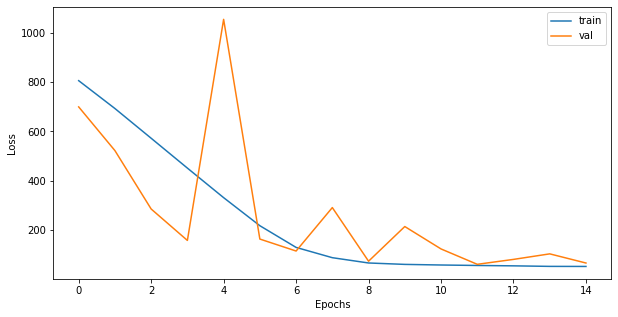

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainer.losses_train, label = "train")
plt.plot(trainer.losses_val, label = "val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

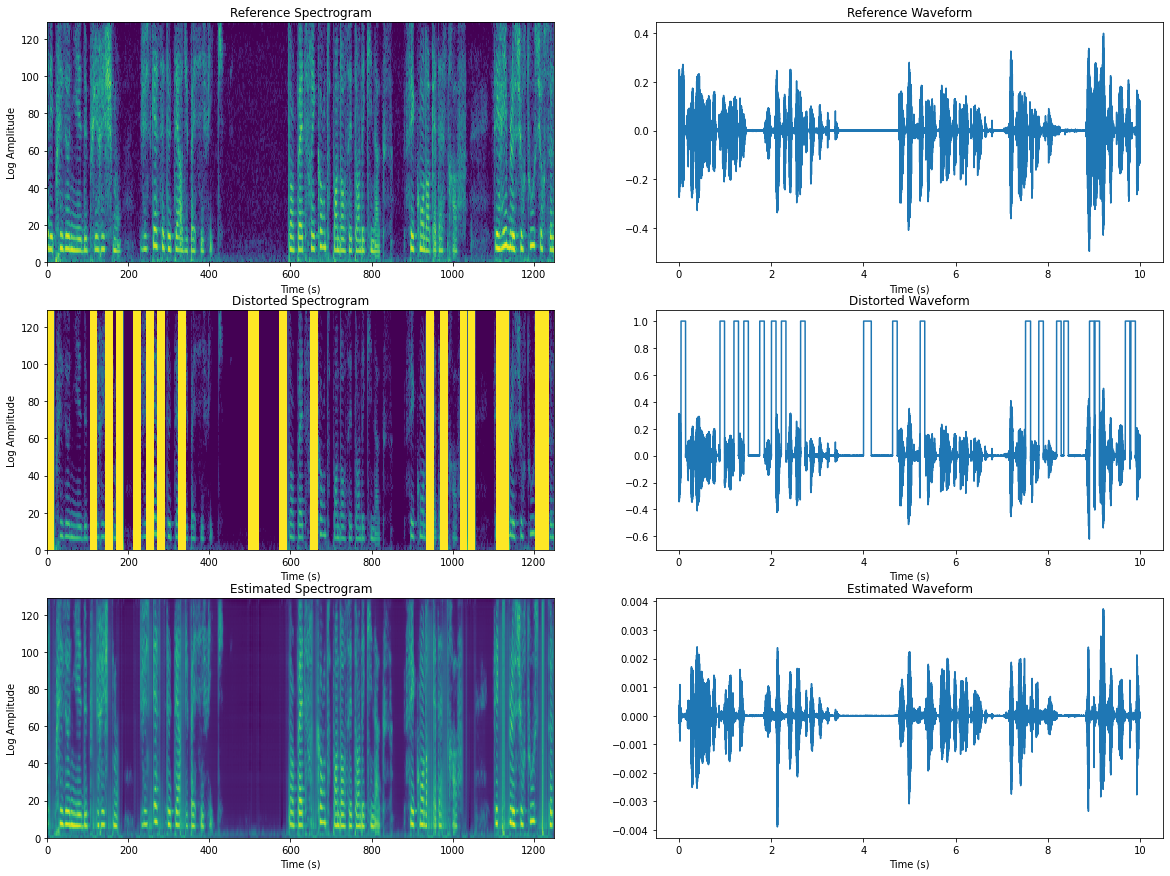

In [ ]:
display_example(dataset_test, trainer.model, device)

In [ ]:
dict_metrics = trainer.predict(dataset_test, batch_size = 32, return_metrics= True) 

100%|██████████| 25/25 [43:08<00:00, 103.55s/it]


In [ ]:
print(f"Loss: {dict_metrics['loss'].item() :.3f}\n"
      f"STOI: {dict_metrics['stoi'] :.3f}")

Loss: 54.464
STOI: 0.796


### Experiment 2

Testing interpolation for a sharper approximation.

In [ ]:
dataset_train.augment = False
dataset_train.fill_gaps = "interpolate"
dataset_val.fill_gaps = "interpolate"
dataset_test.fill_gaps = "interpolate"

model = UNET()

# Optimizer
lr = 1
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

trainer = Trainer(model, Loss_Partial, optimizer, device)

trainer.train(dataset_train, dataset_val, n_epochs = 15, batch_size = 32, 
              enable_autocast = False, enable_GradScaler= False)


Creating model with a basic decoder for the last layer.


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]



Epoch 0 | loss_train: 805.980  | loss_val: 727.709 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Epoch 1 | loss_train: 692.392  | loss_val: 600.893 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Epoch 2 | loss_train: 571.209  | loss_val: 397.410 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.20s/it]



Epoch 3 | loss_train: 450.556  | loss_val: 376.251 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Epoch 4 | loss_train: 330.040  | loss_val: 219.393 

Best model saved.



100%|██████████| 10/10 [00:11<00:00,  1.20s/it]



Epoch 5 | loss_train: 216.050  | loss_val: 293.565 



100%|██████████| 10/10 [00:12<00:00,  1.20s/it]



Epoch 6 | loss_train: 118.924  | loss_val: 236.630 



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Epoch 7 | loss_train: 64.393   | loss_val: 154.913 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.24s/it]



Epoch 8 | loss_train: 60.919   | loss_val: 76.628  

Best model saved.



100%|██████████| 10/10 [00:11<00:00,  1.20s/it]



Epoch 9 | loss_train: 57.205   | loss_val: 80.143  



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]



Epoch 10 | loss_train: 54.612   | loss_val: 84.871  



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]



Epoch 11 | loss_train: 53.547   | loss_val: 72.765  

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Epoch 12 | loss_train: 52.167   | loss_val: 62.147  

Best model saved.



100%|██████████| 10/10 [00:11<00:00,  1.19s/it]



Epoch 13 | loss_train: 51.223   | loss_val: 75.824  



100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch 14 | loss_train: 50.547   | loss_val: 59.176  

Best model saved.



Text(0, 0.5, 'Loss')

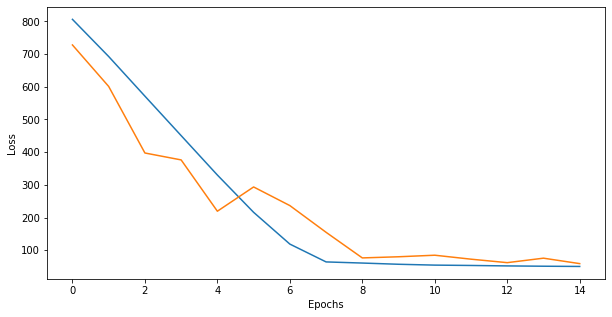

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainer.losses_train, label = "train")
plt.plot(trainer.losses_val, label = "val")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#torch.save(trainer.best_model.state_dict(), "/content/gdrive/My Drive/MVA_courses/Labs/model_exp2.pt")

Mounted at /content/gdrive


In [ ]:
!gdown "https://drive.google.com/uc?id=1GkD0BJKJAhsE9pJ-6mS5bJakFH7gQOym&confirm=t"
trainer.model.load_state_dict(torch.load("/content/model_exp2.pt"))

Downloading...
From: https://drive.google.com/uc?id=1GkD0BJKJAhsE9pJ-6mS5bJakFH7gQOym&confirm=t
To: /content/model_exp2.pt
100% 5.60M/5.60M [00:00<00:00, 234MB/s]


<All keys matched successfully>

torch.Size([1, 1, 129, 1251])


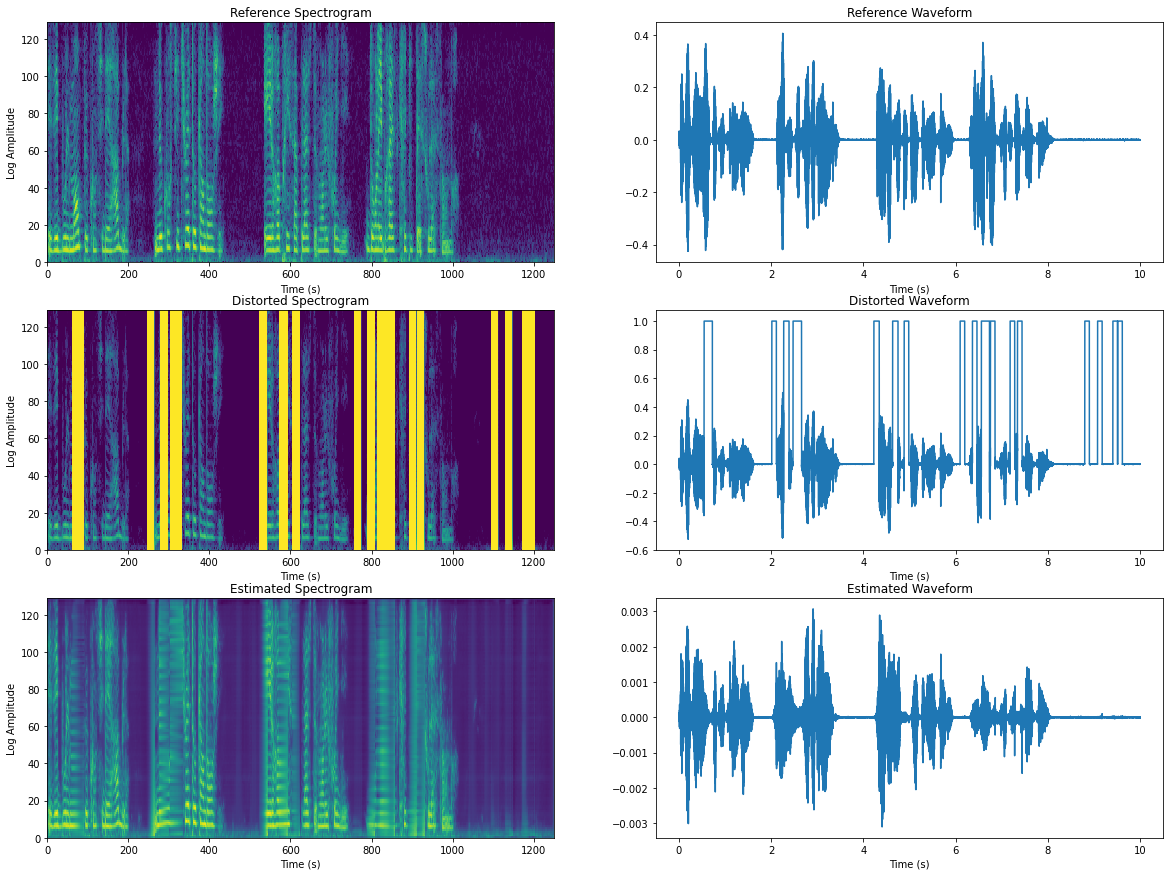

In [ ]:
display_example(dataset_test, trainer.best_model, device)

In [ ]:
dict_metrics = trainer.predict(dataset_test, batch_size = 32, return_metrics= True) 

100%|██████████| 25/25 [36:20<00:00, 87.21s/it]


In [ ]:
print(f"Loss: {dict_metrics['loss'].item() :.3f}\n"
      f"STOI: {dict_metrics['stoi'] :.3f}")

Loss: 80.018
STOI: 0.717


### Experiment 3

Applying Partial Convolutions.

In [ ]:
dataset_train.fill_gaps = "constant"
dataset_val.fill_gaps = "constant"
dataset_test.fill_gaps = "constant"

model = UNET_PartialConv()

# Optimizer
lr = 1
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

trainer = Trainer(model, Loss_Partial, optimizer, device)

In [ ]:
trainer.train(dataset_train, dataset_val, n_epochs = 15, batch_size = 32, 
              enable_autocast = False, enable_GradScaler= False)


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]



Epoch 0 | loss_train: 804.962  | loss_val: 623.314 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 1 | loss_train: 688.166  | loss_val: 365.767 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.26s/it]



Epoch 2 | loss_train: 566.407  | loss_val: 180.037 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 3 | loss_train: 450.082  | loss_val: 355.799 



100%|██████████| 10/10 [00:12<00:00,  1.24s/it]



Epoch 4 | loss_train: 329.898  | loss_val: 454.295 



100%|██████████| 10/10 [00:12<00:00,  1.23s/it]



Epoch 5 | loss_train: 218.816  | loss_val: 364.094 



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 6 | loss_train: 125.110  | loss_val: 113.535 

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 7 | loss_train: 75.249   | loss_val: 89.027  

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 8 | loss_train: 66.835   | loss_val: 239.525 



100%|██████████| 10/10 [00:12<00:00,  1.24s/it]



Epoch 9 | loss_train: 61.018   | loss_val: 81.483  

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 10 | loss_train: 57.581   | loss_val: 87.951  



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 11 | loss_train: 55.940   | loss_val: 69.676  

Best model saved.



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch 12 | loss_train: 55.145   | loss_val: 83.424  



100%|██████████| 10/10 [00:12<00:00,  1.26s/it]



Epoch 13 | loss_train: 54.750   | loss_val: 136.836 



100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch 14 | loss_train: 54.358   | loss_val: 67.903  

Best model saved.



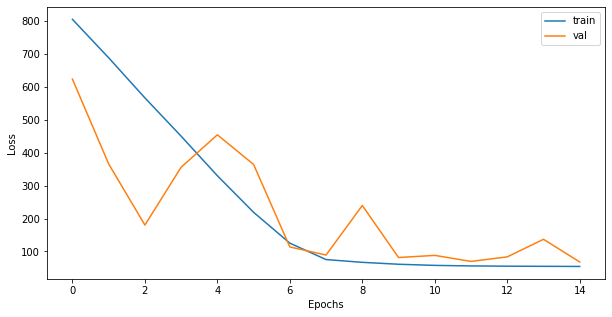

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainer.losses_train, label = "train")
plt.plot(trainer.losses_val, label = "val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

torch.Size([1, 1, 129, 1251])


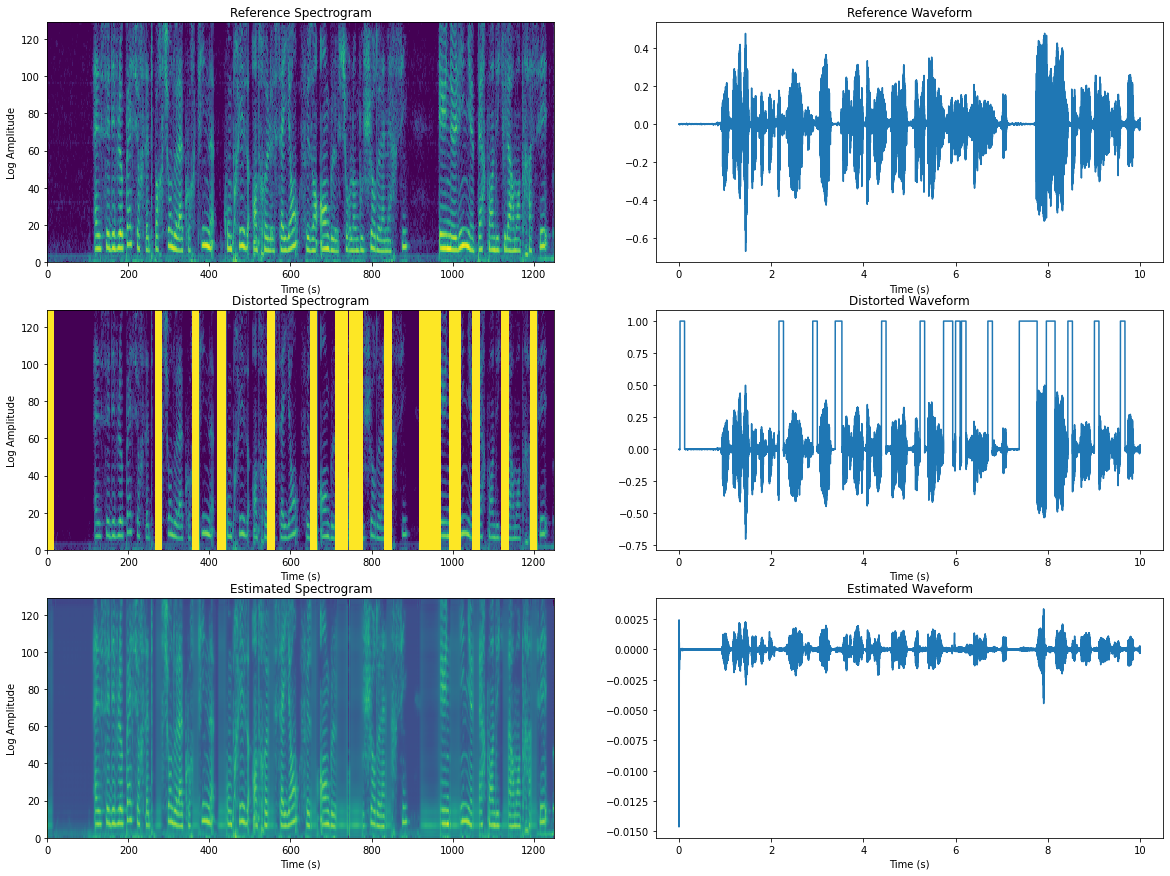

In [ ]:
display_example(dataset_val, trainer.best_model, device)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#torch.save(trainer.best_model.state_dict(), "/content/gdrive/My Drive/MVA_courses/Labs/model_exp3.pt")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!gdown "https://drive.google.com/uc?id=1-54Jl-GvDX3BYknS7eGzP8qJlBl6NiT1&confirm=t"
trainer.model.load_state_dict(torch.load("/content/model_exp3.pt"))

Downloading...
From: https://drive.google.com/uc?id=1-54Jl-GvDX3BYknS7eGzP8qJlBl6NiT1&confirm=t
To: /content/model_exp3.pt
100% 10.3M/10.3M [00:00<00:00, 183MB/s]


<All keys matched successfully>

In [ ]:
dict_metrics = trainer.predict(dataset_test, batch_size = 32, return_metrics= True) 

100%|██████████| 25/25 [37:10<00:00, 89.20s/it]


In [ ]:
print(f"Loss: {dict_metrics['loss'].item() :.3f}\n"
      f"STOI: {dict_metrics['stoi'] :.3f}")

Loss: 62.841
STOI: 0.790


## Complexity


## Conclusion

In [ ]:
def Audio_from_STFT(S, stft_config):
  win_length = stft_config["nperseg"]
  hop_length = (win_length - stft_config["noverlap"])
  S = librosa.db_to_amplitude(S)
  audio = griffinlim(S, n_iter = 200,
                       hop_length =  hop_length,
                       win_length = win_length)
  return audio

In [ ]:
def display_example(dataset, model, device, id = None):

  if id is None:
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 2,
                                                shuffle = True)
    batch_data = next(iter(dataloader))
  
  else:
    batch_data = dataset[id]
    keys = ["S_ref", "S_clicks", "mask_clicks"]
    for key in keys:
      batch_data[key] = torch.from_numpy(batch_data[key]).unsqueeze(0)

  # Data to GPU
  S_clicks = batch_data["S_clicks"][0].unsqueeze(0).unsqueeze(0).to(device)

  mask_clicks = batch_data["mask_clicks"][0].unsqueeze(0).unsqueeze(0).to(device)
  S_ref = batch_data["S_ref"][0]

  # forward 
  S_rec = trainer.model(S_clicks, mask_clicks).squeeze().detach().cpu()

  fig, axes = plt.subplots(3,2, figsize =(20,15))
  axes[0,0].pcolormesh(S_ref)
  axes[0,0].set_title("Reference Spectrogram")
  axes[0,0].set_xlabel("Time (s)")
  axes[0,0].set_ylabel("Log Amplitude")

  axes[1,0].pcolormesh(S_clicks.cpu()[0,0] * mask_clicks.cpu()[0,0])
  axes[1,0].set_title("Distorted Spectrogram")
  axes[1,0].set_xlabel("Time (s)")
  axes[1,0].set_ylabel("Log Amplitude") 

  axes[2,0].pcolormesh(S_rec)
  axes[2,0].set_title("Estimated Spectrogram")
  axes[2,0].set_xlabel("Time (s)")
  axes[2,0].set_ylabel("Log Amplitude") 

  # Reconstruct Audio
  audio_rec = Audio_from_STFT(S_rec.numpy(), dataset.stft_config)

  # Plot waveform
  audio_ref = batch_data["waveform_ref"][0]
  mask_clicks = batch_data["mask_clicks"][0]
  audio_clicks = batch_data["waveform_clicks"][0] 

  rate = 8000
  t = np.arange(len(audio_ref)) / rate

  axes[0,1].plot(t, audio_ref)
  axes[0,1].set_title("Reference Waveform")
  axes[0,1].set_xlabel("Time (s)")

  axes[1,1].plot(t, audio_clicks)
  axes[1,1].set_title("Distorted Waveform")
  axes[1,1].set_xlabel("Time (s)")

  axes[2,1].plot(t, audio_rec)
  axes[2,1].set_title("Estimated Waveform")
  axes[2,1].set_xlabel("Time (s)")

  # Listen to difference

  ipd.display(Audio(data = audio_ref, rate = rate))
  ipd.display(Audio(data = audio_rec, rate = rate))